## Importing the libraries

In [17]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error

%matplotlib inline 

## Loading the interim data sets 

In [18]:
interim_data_directory = "..\\data\\interim\\"
!dir $interim_data_directory

 Volume in drive E is DATA
 Volume Serial Number is 6E98-6AE7

 Directory of E:\GitHub\DataDriven.org\TimeSeries_Energy_Forecasting\Energy_Forecasting\data\interim

10/14/2018  03:40 PM    <DIR>          .
10/14/2018  03:40 PM    <DIR>          ..
10/13/2018  03:18 PM                 0 .gitkeep
10/14/2018  03:41 PM        33,193,146 energy_df.pkl
10/14/2018  03:41 PM           118,993 meta_df.pkl
               3 File(s)     33,312,139 bytes
               2 Dir(s)  1,926,685,278,208 bytes free


In [19]:
# Importing the energy consumption interim data
filename = interim_data_directory + 'energy_df.pkl'
print(filename)
energy_df = pd.read_pickle(filename)
energy_df.shape

..\data\interim\energy_df.pkl


(509376, 8)

In [20]:
energy_df.head()

,series_id,timestamp,consumption,temperature,timestamp_weekday,surface,base_temperature,weekly
0,103088,2014-12-24 00:00:00,101842.233424,NaN,Wednesday,x-small,low,1111100
1,103088,2014-12-24 01:00:00,105878.048906,NaN,Wednesday,x-small,low,1111100
2,103088,2014-12-24 02:00:00,91619.105008,NaN,Wednesday,x-small,low,1111100
3,103088,2014-12-24 03:00:00,94473.706203,NaN,Wednesday,x-small,low,1111100
4,103088,2014-12-24 04:00:00,96976.755526,NaN,Wednesday,x-small,low,1111100


In [21]:
# Number of unique time series
len(energy_df['series_id'].unique())

758

## Extracting the 'always on' buildings to test ARIMA modeling 

In [22]:
always_on_df = energy_df[energy_df['weekly'] == '1111111']
always_on_df.head()

,series_id,timestamp,consumption,temperature,timestamp_weekday,surface,base_temperature,weekly
47040,100793,2017-03-10 00:00:00,18718.178064,20.875,Friday,x-small,low,1111111
47041,100793,2017-03-10 01:00:00,12453.214094,19.000,Friday,x-small,low,1111111
47042,100793,2017-03-10 02:00:00,9512.516721,17.000,Friday,x-small,low,1111111
47043,100793,2017-03-10 03:00:00,7914.311627,16.525,Friday,x-small,low,1111111
47044,100793,2017-03-10 04:00:00,8285.095208,17.000,Friday,x-small,low,1111111


In [23]:
always_on_df.shape

(48384, 8)

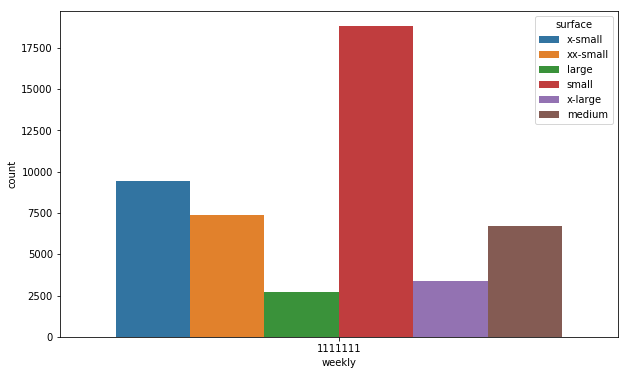

In [24]:
# Number of buildings for each weekly group deparated by their surface
plt.figure(figsize=(10,6))
sns.countplot(x="weekly", data=always_on_df, hue="surface")

### Chose at random a time series from the always on building group

In [25]:
import random
rand_series_id = random.choice(always_on_df.series_id.unique())
rand_series_id

103116

In [26]:
series_101132_df = always_on_df[always_on_df.series_id == 101132]
series_101132_df.shape

(672, 8)

In [27]:
ts_101132 = pd.Series(series_101132_df['consumption'].values, index=series_101132_df['timestamp'])
ts_101132.head()

timestamp
2017-05-03 00:00:00    5325.997527
2017-05-03 01:00:00    2666.702517
2017-05-03 02:00:00    2644.479996
2017-05-03 03:00:00    2770.407615
2017-05-03 04:00:00    2629.664982
dtype: float64

In [28]:
#fit model
model = ARIMA(ts_101132, order=(5,1,0))
model_fit = model.fit(disp=0)
# summary of fit model
print(model_fit.summary())

C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  671
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -7573.144
Method:                       css-mle   S.D. of innovations          19280.533
Date:                Sun, 14 Oct 2018   AIC                          15160.289
Time:                        21:14:13   BIC                          15191.850
Sample:                    05-03-2017   HQIC                         15172.513
                         - 05-30-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.2088    407.596      0.099      0.921    -758.664     839.081
ar.L1.D.y     -0.0589      0.037     -1.614      0.107      -0.130       0.013
ar.L2.D.y     -0.2134      0.036     -5.934      0.0

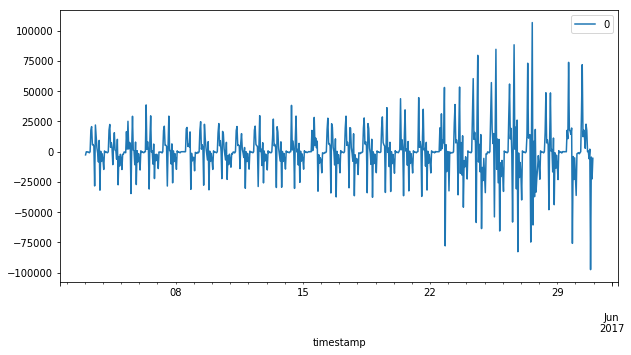

In [29]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(10,5))
plt.show()

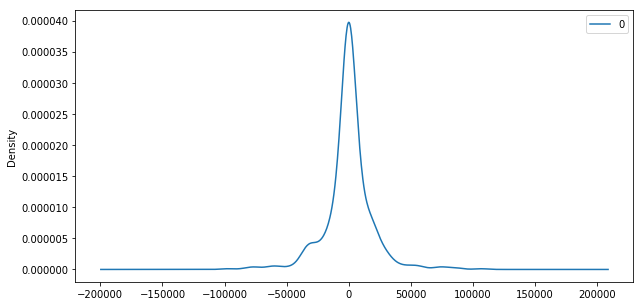

                   0
count     671.000000
mean        4.143396
std     19294.963892
min    -97544.583102
25%     -5087.250970
50%      -173.758274
75%      5973.367755
max    106662.728212


In [30]:
# density plot of residuals
residuals.plot(kind='kde',figsize=(10,5))
plt.show()
# summary stats of residuals
print(residuals.describe())

### ARIMA Forecast with the Time Series chosen at Random

In [31]:
# Simple the time series in test and validation 66%/33% split
test_train_split = 0.66
X = ts_101132.values
train_length = int(len(X) * test_train_split)
train_set, test_set = X[0:train_length], X[train_length:len(X)]

In [32]:
# walk-forward validation
predictions = list()
history = [x for x in train_set]
for timestamp_i in range(len(test_set)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    preds = output[0]
    predictions.append(preds)
    y = test_set[timestamp_i]
    history.append(y)
    #print('predicted=%f, expected=%f' % (preds, y))

print (len(history))

672


MAE on test set: 17625.858


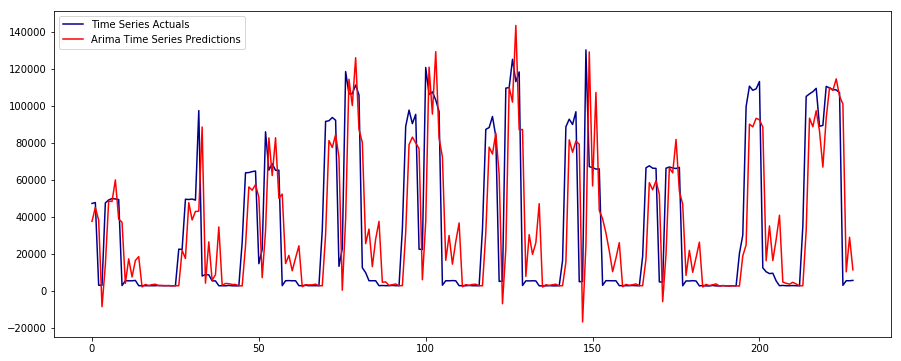

In [33]:
# evaluate forecasts
mae = mean_absolute_error(test_set, predictions)
print('MAE on test set: %.3f' % mae)
# plot forecasts against actual outcomes
plt.figure(figsize=(15,6))
plt.plot(test_set, color='darkblue', label='Time Series Actuals')
plt.plot(predictions, color='red', label='Arima Time Series Predictions')
plt.legend(loc='upper left')
plt.show()

## ARIMA Model Evaluation
### Grid Search

In [43]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train_set, test_set = X[0:train_size], X[train_size:]
    history = [x for x in train_set]
    # make predictions
    predictions = list()
    for timestamp_i in range(len(test_set)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        preds = model_fit.forecast()[0]
        predictions.append(preds)
        y = test_set[timestamp_i]
        history.append(y)
    
    # calculate out of sample error
    mae = mean_absolute_error(test_set, predictions)
    
    residuals = [test_set[i]-predictions[i] for i in range(len(test_set))]
    residuals = pd.DataFrame(residuals)
    return mae, residuals


# evaluate combinations of p, d and q values for an ARIMA model
# p: The number of lag observations included in the model, also called the lag order.
# d: The number of times that the raw observations are differenced, also called the degree of differencing.
# q: The size of the moving average window, also called the order of moving average

def evaluate_arima_models(time_series, p_values, d_values, q_values):
    print("evaluate_arima_models: number of oders to try is {}".format(len(p_values)*len(d_values)*len(q_values)))
    best_score = None
    best_cfg = None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mae, res = evaluate_arima_model(time_series, order)
                    if (best_score is None):
                            best_score = mae
                    print("evaluate_arima_models: MAE={.3f} for order: p={} d={} q={}".format(mae, p,d,q)) 
                    if rmse < best_score:
                        best_score, best_cfg = mae, order
                except:
                    continue
    print('Best ARIMA model: %s with MAE=%.3f' % (best_cfg, best_score))

In [ ]:
import warnings

p_val = [0, 1, 3]
d_val = range(0, 3)
q_val = [1 , 3, 7]
warnings.filterwarnings("ignore")
best_model = evaluate_arima_models(ts_101132.values, p_values = p_val , d_values = d_val,  q_values = q_val)

### Review Residual Errors

In [44]:
mae, residuals_df = evaluate_arima_model(ts_101132.values, (0,1,1))
print("mae = %.3f" % mae)

C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


mae = 13484.739


In [45]:
residuals_df.head()

,0
0,-1281.849436
1,440.235737
2,-44773.354496
3,1835.222030
4,44395.004654


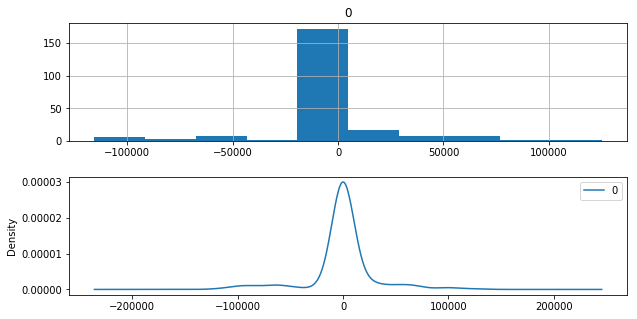

In [47]:
#residuals = [test[i]-predictions[i] for i in range(len(test))]
#residuals = DataFrame(residuals)
plt.figure(figsize=(10,5))
plt.subplot(211)
residuals_df.hist(ax=plt.gca())
plt.subplot(212)
residuals_df.plot(kind='kde', ax=plt.gca())
plt.show()

### Now let's generate a forecast

In [49]:
model = ARIMA(ts_101132, order= (0,1,1))
model_fit = model.fit(disp=0)
# forecast the next 7 days
forecast = model_fit.forecast(steps=7)[0]

C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [52]:
forecast

array([5568.42862061, 5568.79292423, 5569.15722785, 5569.52153148,
       5569.8858351 , 5570.25013872, 5570.61444234])

In [60]:
ts_101132.tail()

timestamp
2017-05-30 19:00:00    106949.585939
2017-05-30 20:00:00      2918.557755
2017-05-30 21:00:00      5400.072597
2017-05-30 22:00:00      5377.850076
2017-05-30 23:00:00      5570.445257
dtype: float64

In [63]:
ts_101132[-7:]

timestamp
2017-05-30 17:00:00    108631.090026
2017-05-30 18:00:00    108445.902351
2017-05-30 19:00:00    106949.585939
2017-05-30 20:00:00      2918.557755
2017-05-30 21:00:00      5400.072597
2017-05-30 22:00:00      5377.850076
2017-05-30 23:00:00      5570.445257
dtype: float64